# Pulse Shaping Demo

System model: Source --> QPSK --> Pulse Shaping

This imports but a few common Python libraries

In [15]:
# import packages for scientific python and plotting
import numpy as np
import scipy.signal as sig
import matplotlib.pyplot as plt
%matplotlib inline

#### Define RRC filter

In [17]:
def get_rrc_ir(K, n_up, t_symb, beta):
        
    ''' 
    Determines coefficients of an RRC filter 
    
    Formula out of: J. Huber, Trelliscodierung, Springer, 1992, S. 15
    At poles, values of wikipedia.de were used (without cross-checking)
    
    NOTE: Length of the IR has to be an odd number
    
    IN: length of IR, upsampling factor, symbol time, roll-off factor
    OUT: filter ceofficients
    '''

    assert K%2 != 0, "Filter length needs to be odd"
    if beta == 0:
        beta = 1e-32

    # init
    rrc = np.zeros(K)
    t_sample = t_symb/n_up
    
    if K%2 != 0:
        i_steps = np.arange(0,K)
        k_steps = np.arange(-(K-1)/2.0,(K-1)/2.0+1)    
        t_steps = k_steps*t_sample
        for i in i_steps:
            if t_steps[i] == 0:
                rrc[i] = 1.0/np.sqrt(t_symb)*(1.0-beta+4.0*beta/np.pi)
            elif np.abs(t_steps[i]) == t_symb/4.0/beta:
                rrc[i] = beta/np.sqrt(2.0*t_symb)*((1+2/np.pi)*np.sin(np.pi/4.0/beta)+(1.0-2.0/np.pi)*np.cos(np.pi/4.0/beta))
            else:
                rrc[i] = 1.0/np.sqrt(t_symb)*(np.sin(np.pi*t_steps[i]/t_symb*(1-beta))+4.0*beta*t_steps[i]/t_symb*np.cos(np.pi*t_steps[i]/t_symb*(1+beta)))/(np.pi*t_steps[i]/t_symb*(1.0-(4.0*beta*t_steps[i]/t_symb)**2.0))
 
    return rrc

#### System parameters

In [18]:
# Number of simulated symbols
K = 65536

# Upsampling (Samples per Symbol)
N = 8

# RRC-Filter, Rolloff-factor, Number of filter coefficients
alpha = 0.35
N_rrc = N*4+1

# FFT Length
N_FFT = 512

# Test parameters
assert (K > 0 and (K & (K - 1)) == 0), 'K muss eine Potenz von 2 sein'
assert (N > 0 and N%2 == 0), 'N muss groesser Null sein und gerade'
assert (alpha >= 0 and alpha <= 1), 'Fuer den Rolloff-Faktor gilt: 0 <= alpha <= 1'
assert (N_rrc > 0 and N_rrc%2 != 0), 'N_rrc muss groesser Null sein und ungerade'

#### Transmitter

In [20]:
# create QPSK symbols
s = 2 * np.random.randint(2, size=K)-1 + 1j * (2*np.random.randint(2, size=K)-1)

# Power normalization
s = 1/np.sqrt(2)*s

# Upsampling by factor N
s_up = np.zeros(K*N,complex)
s_up[::N] = s;

# Rectangle filter
h_rect = np.ones(N)
s_tx_rect = sig.lfilter(h_rect,1,s_up)
s_tx_rect = 1/np.sqrt(np.mean(np.abs(s_tx_rect)**2))*s_tx_rect
print("Mean Power of s_tx_rect = %f" % np.mean(np.abs(s_tx_rect)**2))

# Triangular filter
h_tri = np.concatenate([np.arange(0,int(N)+1),np.arange(int(N)-1,0,-1)])
s_tx_tri = sig.lfilter(h_tri,1,s_up)
s_tx_tri = 1/np.sqrt(np.mean(np.abs(s_tx_tri)**2))*s_tx_tri
print("Mean Power of s_tx_tri  = %f" % np.mean(np.abs(s_tx_tri)**2))

# Root-Raised-Cosine (RRC) filter 
h_rrc = get_rrc_ir(N_rrc,N,1.0,alpha)
s_tx_rrc = sig.lfilter(h_rrc,1,s_up)
s_tx_rrc = 1/np.sqrt(np.mean(np.abs(s_tx_rrc)**2))*s_tx_rrc
print("Mean Power of s_tx_rect = %f" % np.mean(np.abs(s_tx_rrc)**2))

Mean Power of s_tx_rect = 1.000000
Mean Power of s_tx_tri  = 1.000000
Mean Power of s_tx_rect = 1.000000


#### Graphics

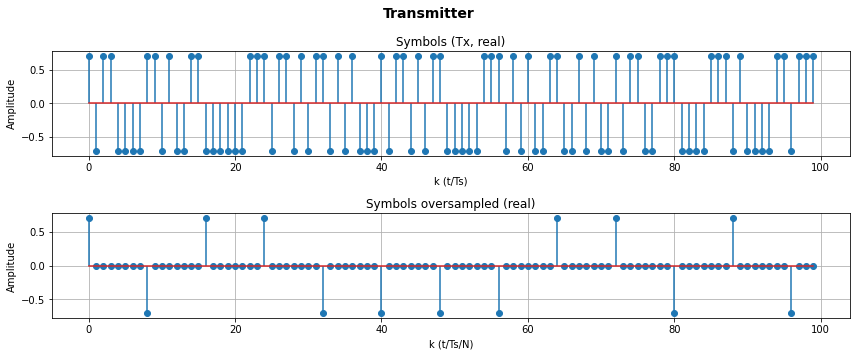

In [30]:
# Einschwingzeit RRC Filter (Hilfsgroesse)
N_osc = (N_rrc-1)/2


fig1 = plt.figure(figsize=(12,5))
fig1.suptitle("Transmitter", fontsize=14, fontweight='bold')

ax1 = fig1.add_subplot(2,1,1)
ax1.set_title('Symbols (Tx, real)')
ax1.stem(np.array(range(100)),s.real[:100])
ax1.grid(True)
ax1.set_xlabel('k (t/Ts)')
ax1.set_ylabel('Amplitude')

ax2 = fig1.add_subplot(2,1,2)
ax2.set_title('Symbols oversampled (real)')
ax2.stem(np.array(range(100)),s_up.real[:100])
ax2.grid(True)
ax2.set_xlabel('k (t/Ts/N)')
ax2.set_ylabel('Amplitude')
plt.tight_layout()

In [ ]:
fig2 = plt.figure(figsize=(12,5))
fig2.suptitle("Pulse shaping (rect)", fontsize=14, fontweight='bold')

ax1 = fig2.add_subplot(1,3,1)
ax1.set_title('Impulse response rect')
ax1.stem(np.arange(np.ceil(-N/2),np.ceil(N/2)),h_rect)
ax1.set_xlim(-N_osc,N_osc+1)
ax1.set_ylim(-0.1,1.1)
ax1.grid(True)
ax1.set_xlabel('k (t/Ts/N)')
ax1.set_ylabel('Amplitude')

ax2 = fig2.add_subplot(1,3,2)
ax2.set_title('Signal after rect pulse shaping (real, blue)')
ax2.plot(np.array(range(256)),s_tx_rect.real[0:256])
ax2.plot(np.array(np.arange(0,256,N)),np.real(s[0:int(np.ceil(256/N))]),'go',markersize=4)
ax2.set_xlim(0,256)
ax2.grid(True)
ax2.set_xlabel('k (t/Ts/N)')
ax2.set_ylabel('Amplitude')

ax3 = fig2.add_subplot(1,3,3)
ax3.set_title('PSD Rechteck-Pulsformung')
Pxx_rect = 1/(K*N/N_FFT)*np.abs(np.fft.fftshift(np.fft.fft(np.reshape(s_tx_rect,(-1,N_FFT)),axis=1))).sum(0)
f = np.linspace(-0.5,0.5,len(Pxx_rect))
ax3.semilogy(f, Pxx_rect, 'b')
ax3.set_xlim(-0.5,0.5)
ax3.set_ylim([1e-1, np.sqrt(N*K)])
ax3.grid(True)
ax3.set_xlabel('n (f/N/Ts)')
plt.tight_layout()

In [ ]:
fig3 = plt.figure(figsize=(12,5))
fig3.suptitle("Pulse shaping (triangle)", fontsize=14, fontweight='bold')

ax1 = fig3.add_subplot(1,3,1)
ax1.set_title('Impulse response tri')
ax1.stem(np.arange(np.ceil(-N),np.ceil(N)),h_tri)
ax1.set_xlim(-N_osc,N_osc+1)
ax1.set_ylim(-0.1,1.1*np.max(h_tri))
ax1.grid(True)
ax1.set_xlabel('k (t/Ts/N)')
ax1.set_ylabel('Amplitude')

ax2 = fig3.add_subplot(1,3,2)
ax2.set_title('Signal after triangular pulse shaping (real, blue)')
ax2.plot(np.array(range(256)),s_tx_tri.real[N//2:256+N//2])
ax2.plot(np.array(np.arange(0,256,N)),np.real(s[0:int(np.ceil(256/N))]),'go',markersize=4)
ax2.set_xlim(0,256)
ax2.grid(True)
ax2.set_xlabel('k (t/Ts/N)')
ax2.set_ylabel('Amplitude')

ax3 = fig3.add_subplot(1,3,3)
ax3.set_title('PSD triangular pulse shaping')
Pxx_tri = 1/(K*N/N_FFT)*np.abs(np.fft.fftshift(np.fft.fft(np.reshape(s_tx_tri,(-1,N_FFT)),axis=1))).sum(0)
f = np.linspace(-0.5,0.5,len(Pxx_tri))
ax3.semilogy(f, Pxx_tri, 'b')
ax3.set_xlim(-0.5,0.5)
ax3.set_ylim([1e-1, np.sqrt(N*K)])
ax3.grid(True)
ax3.set_xlabel('n (f/N/Ts)')

Energy of Pxx_rect = 0.790839
Energy of Pxx_tri  = 0.791067
Energy of Pxx_rrc  = 0.790959

Energy of Pxx_rect (-0.05...+0.05) = 0.535612
Energy of Pxx_tri (-0.05...+0.05)  = 0.687043
Energy of Pxx_rrc (-0.05...+0.05)  = 0.634618



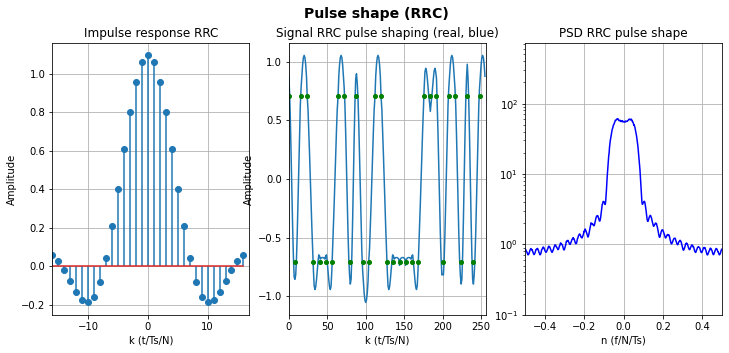

In [31]:
fig4 = plt.figure(figsize=(12,5))
fig4.suptitle("Pulse shape (RRC)", fontsize=14, fontweight='bold')

ax1 = fig4.add_subplot(1,3,1)
ax1.set_title('Impulse response RRC')
ax1.stem(np.array(np.arange(-N_osc,N_osc+1)),h_rrc)
ax1.set_xlim(-N_osc,N_osc+1)
ax1.grid(True)
ax1.set_xlabel('k (t/Ts/N)')
ax1.set_ylabel('Amplitude')

ax2 = fig4.add_subplot(1,3,2)
ax2.set_title('Signal RRC pulse shaping (real, blue)')
ax2.plot(np.array(range(256)),s_tx_rrc.real[(N_rrc-1)//2:256+(N_rrc-1)//2])
ax2.plot(np.array(np.arange(0,256,N)),np.real(s[0:int(np.ceil(256/N))]),'go',markersize=4)
ax2.set_xlim(0,256)
ax2.grid(True)
ax2.set_xlabel('k (t/Ts/N)')
ax2.set_ylabel('Amplitude')

ax3 = fig4.add_subplot(1,3,3)
ax3.set_title('PSD RRC pulse shape')
Pxx_rrc = 1/(K*N/N_FFT)*np.abs(np.fft.fftshift(np.fft.fft(np.reshape(s_tx_rrc,(-1,N_FFT)),axis=1))).sum(0)
f = np.linspace(-0.5,0.5,len(Pxx_rrc))
ax3.semilogy(f, Pxx_rrc, 'b')
ax3.set_xlim(-0.5,0.5)
ax3.set_ylim([1e-1, np.sqrt(N*K)])
ax3.grid(True)
ax3.set_xlabel('n (f/N/Ts)')

Energy of Pxx_rect = 0.790839
Energy of Pxx_tri  = 0.791067
Energy of Pxx_rrc  = 0.790959

Energy of Pxx_rect (-0.05...+0.05) = 0.535612
Energy of Pxx_tri (-0.05...+0.05)  = 0.687043
Energy of Pxx_rrc (-0.05...+0.05)  = 0.634618



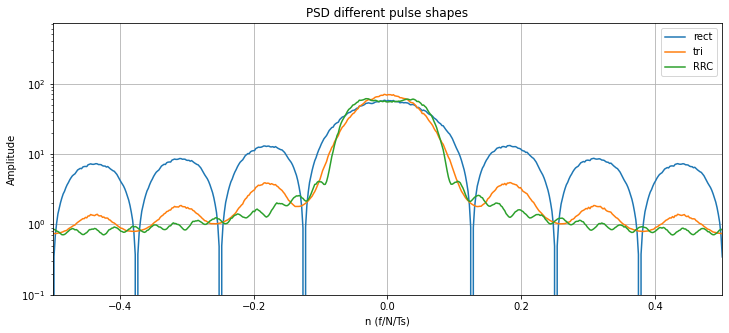

In [36]:
print ("Energy of Pxx_rect = %f" % (np.sum(np.abs(Pxx_rect*(f[2]-f[1]))**2)))
print ("Energy of Pxx_tri  = %f" % (np.sum(np.abs(Pxx_tri*(f[2]-f[1]))**2)))
print ("Energy of Pxx_rrc  = %f\n" % (np.sum(np.abs(Pxx_rrc*(f[2]-f[1]))**2)))

n_start = np.argmin(np.abs(f+0.05))
n_stop  = np.argmin(np.abs(f-0.05))

print ("Energy of Pxx_rect (-0.05...+0.05) = %f" % (np.sum(np.abs(Pxx_rect[n_start:n_stop]*(f[2]-f[1]))**2)))
print ("Energy of Pxx_tri (-0.05...+0.05)  = %f" % (np.sum(np.abs(Pxx_tri[n_start:n_stop]*(f[2]-f[1]))**2)))
print ("Energy of Pxx_rrc (-0.05...+0.05)  = %f\n" % (np.sum(np.abs(Pxx_rrc[n_start:n_stop]*(f[2]-f[1]))**2)))


fig5 = plt.figure(figsize=(12,5))

ax1 = fig5.add_subplot(1,1,1)
ax1.semilogy(f,Pxx_rect, label='rect')
ax1.semilogy(f,Pxx_tri, label='tri')
ax1.semilogy(f,Pxx_rrc, label='RRC')

ax1.grid(True)
ax1.set_xlim(-0.5,0.5)
ax1.set_ylim([1e-1, np.sqrt(N*K)])
ax1.set_xlabel('n (f/N/Ts)')
ax1.set_ylabel('Amplitude')
ax1.set_title('PSD different pulse shapes')
ax1.legend()